<a href="https://colab.research.google.com/github/akanksha-th/brain_tumor_mri_classification/blob/master/replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, math, numpy as np, random, time
import torch, torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [2]:
print(f'Torch version: {torch.__version__}')

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Torch version: 2.8.0+cu126
Using device: cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(150),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize
    ]),

    # Just normalization for validation
    'valid': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),

    ]),
}

In [5]:
data_dir = '/content/drive/MyDrive/Tumour'

image_dataset = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
               for x in ['train', 'valid']}
dataloaders = {x: DataLoader(image_dataset[x], batch_size=8, shuffle=True, num_workers=2, persistent_workers=True)
               for x in ['train', 'valid']}

dataset_sizes = {x: len(image_dataset[x]) for x in ['train', 'valid']}
class_names = image_dataset['train'].classes

print(f'Classes: {class_names}')
print(f'Dataset sizes: {dataset_sizes}')
print(f'Number of training batches: {dataloaders["train"].__len__()}')
print(f'Number of validation batches: {dataloaders["valid"].__len__()}')

Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Dataset sizes: {'train': 1695, 'valid': 502}
Number of training batches: 212
Number of validation batches: 63


In [6]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

print(f'Input batch shape: {inputs.size()}')

Input batch shape: torch.Size([8, 3, 150, 150])


In [7]:
class SepConv2d(nn.Module):
    """Separable Convolution = Depthwise Convolution + Pointwise Convolution"""
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False):
        super().__init__()
        self.depth = nn.Conv2d(in_ch, in_ch, kernel_size=kernel_size, stride=stride,
                               padding=padding, groups=in_ch, bias=bias)
        self.point = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, bias=bias)

    def forward(self, x):
        x = self.depth(x)
        x = self.point(x)
        return x


class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block"""
    def __init__(self, channels, reduction=16):
        super().__init__()
        reduced = max(1, channels // reduction)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(channels, reduced)
        self.fc2 = nn.Linear(reduced, channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = torch.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y


class ConvBlock(nn.Module):
    """ConvBlock: SepConv -> BN -> MaxPool -> SEBlock"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.seq = nn.Sequential(
            SepConv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            SEBlock(out_ch)
        )

    def forward(self, x):
        x = self.seq(x)
        return x

In [8]:
class LightCNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=4):
        super().__init__()
        self.block1 = ConvBlock(in_channels, 32)
        self.block2 = ConvBlock(32, 64)
        self.block3 = ConvBlock(64, 128)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(128, 128)
        self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.drop2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.drop1(x)
        x = torch.relu(self.fc2(x))
        x = self.drop2(x)
        logits = self.fc3(x)
        return logits


model = LightCNN(in_channels=3, num_classes=len(class_names)).to(device)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params}\nTotal Trainable Parameters: {trainable_params}")

Total params: 39629
Total Trainable Parameters: 39629


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

In [10]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    pbar = tqdm(dataloader, desc='train', leave=False)
    for inputs, labels in pbar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        preds = torch.argmax(outputs, dim=1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()
        pbar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    return epoch_loss, epoch_acc

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='valid', leave=False)
        for inputs, labels in pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, dim=1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    return epoch_loss, epoch_acc, all_preds, all_labels

In [11]:
NUM_EPOCHS = 300
best_val_acc = 0.0
best_model_path = 'best_custom_model.pth'
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    train_loss, train_acc = train_one_epoch(model, dataloaders['train'], criterion, optimizer, device)
    val_loss, val_acc, val_preds, val_labels = validate_one_epoch(model, dataloaders['valid'], criterion, device)

    scheduler.step(val_loss)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"    train_loss: {train_loss:.4f}    train_acc: {train_acc:.4f}")
    print(f"    val_loss: {val_loss:.4f}    val_acc: {val_acc:.4f}")

    # save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'class_names': class_names
        }, best_model_path)
        print(f"Saved new best model")

total_time = time.time() - start_time
print(f"Training Complete in {total_time/60:.2f} minutes. Best val acc: {best_val_acc:.4f}'")

Epoch 1/300


    train_loss: 1.1894    train_acc: 0.4708
    val_loss: 1.0750    val_acc: 0.5438
Saved new best model
Epoch 2/300


    train_loss: 1.0384    train_acc: 0.5776
    val_loss: 0.8643    val_acc: 0.6614
Saved new best model
Epoch 3/300


    train_loss: 1.0037    train_acc: 0.6047
    val_loss: 1.0689    val_acc: 0.5000
Epoch 4/300


    train_loss: 0.9477    train_acc: 0.6277
    val_loss: 0.7534    val_acc: 0.7052
Saved new best model
Epoch 5/300


    train_loss: 0.9589    train_acc: 0.6171
    val_loss: 1.1926    val_acc: 0.5259
Epoch 6/300


    train_loss: 0.9509    train_acc: 0.6242
    val_loss: 0.8079    val_acc: 0.6793
Epoch 7/300


    train_loss: 0.9381    train_acc: 0.6283
    val_loss: 0.8332    val_acc: 0.6454
Epoch 8/300


    train_loss: 0.8792    train_acc: 0.6472
    val_loss: 0.7631    val_acc: 0.7092
Saved new best model
Epoch 9/300


    train_loss: 0.8802    train_acc: 0.6667
    val_loss: 0.7555    val_acc: 0.6972
Epoch 10/300


    train_loss: 0.8354    train_acc: 0.6708
    val_loss: 0.8865    val_acc: 0.6673
Epoch 11/300


    train_loss: 0.8155    train_acc: 0.6938
    val_loss: 0.9290    val_acc: 0.6394
Epoch 12/300


    train_loss: 0.8104    train_acc: 0.6832
    val_loss: 0.6982    val_acc: 0.7112
Saved new best model
Epoch 13/300


    train_loss: 0.8020    train_acc: 0.6796
    val_loss: 0.6099    val_acc: 0.7988
Saved new best model
Epoch 14/300


    train_loss: 0.7659    train_acc: 0.6956
    val_loss: 0.5460    val_acc: 0.8247
Saved new best model
Epoch 15/300


    train_loss: 0.7664    train_acc: 0.7086
    val_loss: 1.4662    val_acc: 0.5100
Epoch 16/300


    train_loss: 0.7330    train_acc: 0.7263
    val_loss: 0.6584    val_acc: 0.7311
Epoch 17/300


    train_loss: 0.7671    train_acc: 0.7021
    val_loss: 0.7272    val_acc: 0.7191
Epoch 18/300


    train_loss: 0.7636    train_acc: 0.7009
    val_loss: 0.9352    val_acc: 0.6255
Epoch 19/300


    train_loss: 0.7150    train_acc: 0.7209
    val_loss: 0.5799    val_acc: 0.7729
Epoch 20/300


    train_loss: 0.7171    train_acc: 0.7209
    val_loss: 0.7198    val_acc: 0.6892
Epoch 21/300


    train_loss: 0.6963    train_acc: 0.7292
    val_loss: 0.9185    val_acc: 0.6135
Epoch 22/300


    train_loss: 0.7057    train_acc: 0.7434
    val_loss: 0.5669    val_acc: 0.7928
Epoch 23/300


    train_loss: 0.6658    train_acc: 0.7316
    val_loss: 0.5168    val_acc: 0.8207
Epoch 24/300


    train_loss: 0.6818    train_acc: 0.7381
    val_loss: 0.9086    val_acc: 0.6315
Epoch 25/300


    train_loss: 0.6726    train_acc: 0.7510
    val_loss: 0.6781    val_acc: 0.7052
Epoch 26/300


    train_loss: 0.6550    train_acc: 0.7422
    val_loss: 0.6470    val_acc: 0.7430
Epoch 27/300


    train_loss: 0.6634    train_acc: 0.7440
    val_loss: 0.6008    val_acc: 0.7590
Epoch 28/300


    train_loss: 0.6466    train_acc: 0.7528
    val_loss: 0.6740    val_acc: 0.7211
Epoch 29/300


    train_loss: 0.6360    train_acc: 0.7552
    val_loss: 0.5534    val_acc: 0.7888
Epoch 30/300


    train_loss: 0.6683    train_acc: 0.7463
    val_loss: 0.6344    val_acc: 0.7450
Epoch 31/300


    train_loss: 0.6765    train_acc: 0.7434
    val_loss: 0.5190    val_acc: 0.8327
Saved new best model
Epoch 32/300


    train_loss: 0.6575    train_acc: 0.7528
    val_loss: 0.5043    val_acc: 0.8327
Epoch 33/300


    train_loss: 0.6419    train_acc: 0.7493
    val_loss: 0.6033    val_acc: 0.7530
Epoch 34/300


    train_loss: 0.6581    train_acc: 0.7404
    val_loss: 0.6016    val_acc: 0.7729
Epoch 35/300


    train_loss: 0.6623    train_acc: 0.7487
    val_loss: 0.4983    val_acc: 0.8406
Saved new best model
Epoch 36/300


    train_loss: 0.6447    train_acc: 0.7504
    val_loss: 0.5550    val_acc: 0.7928
Epoch 37/300


    train_loss: 0.6223    train_acc: 0.7593
    val_loss: 0.6140    val_acc: 0.7590
Epoch 38/300


    train_loss: 0.6432    train_acc: 0.7569
    val_loss: 0.5561    val_acc: 0.7948
Epoch 39/300


    train_loss: 0.6175    train_acc: 0.7622
    val_loss: 0.6930    val_acc: 0.7032
Epoch 40/300


    train_loss: 0.6219    train_acc: 0.7658
    val_loss: 0.5839    val_acc: 0.7948
Epoch 41/300


    train_loss: 0.6677    train_acc: 0.7422
    val_loss: 0.5874    val_acc: 0.7789
Epoch 42/300


    train_loss: 0.6525    train_acc: 0.7546
    val_loss: 0.6567    val_acc: 0.7231
Epoch 43/300


    train_loss: 0.6440    train_acc: 0.7546
    val_loss: 0.6592    val_acc: 0.7251
Epoch 44/300


    train_loss: 0.6586    train_acc: 0.7493
    val_loss: 0.5896    val_acc: 0.7769
Epoch 45/300


    train_loss: 0.6368    train_acc: 0.7569
    val_loss: 0.6291    val_acc: 0.7510
Epoch 46/300


    train_loss: 0.6214    train_acc: 0.7617
    val_loss: 0.5628    val_acc: 0.7908
Epoch 47/300


    train_loss: 0.6382    train_acc: 0.7499
    val_loss: 0.5695    val_acc: 0.7928
Epoch 48/300


    train_loss: 0.6571    train_acc: 0.7440
    val_loss: 0.6141    val_acc: 0.7610
Epoch 49/300


    train_loss: 0.6713    train_acc: 0.7457
    val_loss: 0.6060    val_acc: 0.7570
Epoch 50/300


    train_loss: 0.6294    train_acc: 0.7622
    val_loss: 0.7042    val_acc: 0.7112
Epoch 51/300


    train_loss: 0.6223    train_acc: 0.7599
    val_loss: 0.5602    val_acc: 0.7948
Epoch 52/300


    train_loss: 0.6394    train_acc: 0.7563
    val_loss: 0.5935    val_acc: 0.7789
Epoch 53/300


    train_loss: 0.6373    train_acc: 0.7540
    val_loss: 0.5671    val_acc: 0.7908
Epoch 54/300


    train_loss: 0.6252    train_acc: 0.7640
    val_loss: 0.5475    val_acc: 0.8068
Epoch 55/300


    train_loss: 0.6251    train_acc: 0.7646
    val_loss: 0.5696    val_acc: 0.7869
Epoch 56/300


    train_loss: 0.6420    train_acc: 0.7563
    val_loss: 0.6408    val_acc: 0.7371
Epoch 57/300


    train_loss: 0.6364    train_acc: 0.7534
    val_loss: 0.6423    val_acc: 0.7430
Epoch 58/300


    train_loss: 0.6395    train_acc: 0.7640
    val_loss: 0.5990    val_acc: 0.7709
Epoch 59/300


    train_loss: 0.6150    train_acc: 0.7782
    val_loss: 0.6304    val_acc: 0.7570
Epoch 60/300


    train_loss: 0.6436    train_acc: 0.7575
    val_loss: 0.5396    val_acc: 0.8147
Epoch 61/300


    train_loss: 0.6331    train_acc: 0.7622
    val_loss: 0.5388    val_acc: 0.8167
Epoch 62/300


    train_loss: 0.6513    train_acc: 0.7499
    val_loss: 0.5493    val_acc: 0.7988
Epoch 63/300


    train_loss: 0.6364    train_acc: 0.7563
    val_loss: 0.6054    val_acc: 0.7669
Epoch 64/300


    train_loss: 0.6125    train_acc: 0.7693
    val_loss: 0.5353    val_acc: 0.8108
Epoch 65/300


    train_loss: 0.6334    train_acc: 0.7670
    val_loss: 0.6297    val_acc: 0.7430
Epoch 66/300


    train_loss: 0.6389    train_acc: 0.7558
    val_loss: 0.6004    val_acc: 0.7749
Epoch 67/300


    train_loss: 0.6229    train_acc: 0.7617
    val_loss: 0.6057    val_acc: 0.7649
Epoch 68/300


    train_loss: 0.6395    train_acc: 0.7558
    val_loss: 0.5531    val_acc: 0.8008
Epoch 69/300


    train_loss: 0.6332    train_acc: 0.7569
    val_loss: 0.5980    val_acc: 0.7709
Epoch 70/300


    train_loss: 0.6622    train_acc: 0.7510
    val_loss: 0.4971    val_acc: 0.8207
Epoch 71/300


    train_loss: 0.6220    train_acc: 0.7646
    val_loss: 0.5390    val_acc: 0.8068
Epoch 72/300


    train_loss: 0.6421    train_acc: 0.7534
    val_loss: 0.6651    val_acc: 0.7311
Epoch 73/300


    train_loss: 0.6432    train_acc: 0.7540
    val_loss: 0.5370    val_acc: 0.8127
Epoch 74/300


    train_loss: 0.6368    train_acc: 0.7575
    val_loss: 0.6116    val_acc: 0.7610
Epoch 75/300


    train_loss: 0.6731    train_acc: 0.7363
    val_loss: 0.5529    val_acc: 0.8028
Epoch 76/300


    train_loss: 0.6232    train_acc: 0.7569
    val_loss: 0.6052    val_acc: 0.7649
Epoch 77/300


    train_loss: 0.6229    train_acc: 0.7617
    val_loss: 0.6102    val_acc: 0.7590
Epoch 78/300


    train_loss: 0.6327    train_acc: 0.7516
    val_loss: 0.5774    val_acc: 0.7869
Epoch 79/300


    train_loss: 0.6363    train_acc: 0.7451
    val_loss: 0.6276    val_acc: 0.7590
Epoch 80/300


    train_loss: 0.6421    train_acc: 0.7605
    val_loss: 0.5450    val_acc: 0.8088
Epoch 81/300


    train_loss: 0.6578    train_acc: 0.7552
    val_loss: 0.5796    val_acc: 0.7849
Epoch 82/300


    train_loss: 0.6307    train_acc: 0.7569
    val_loss: 0.7357    val_acc: 0.6912
Epoch 83/300


    train_loss: 0.6565    train_acc: 0.7445
    val_loss: 0.5835    val_acc: 0.7829
Epoch 84/300


    train_loss: 0.6096    train_acc: 0.7723
    val_loss: 0.5116    val_acc: 0.8227
Epoch 85/300


    train_loss: 0.6345    train_acc: 0.7599
    val_loss: 0.6028    val_acc: 0.7709
Epoch 86/300


    train_loss: 0.6427    train_acc: 0.7534
    val_loss: 0.5811    val_acc: 0.7888
Epoch 87/300


    train_loss: 0.6380    train_acc: 0.7522
    val_loss: 0.6093    val_acc: 0.7729
Epoch 88/300


    train_loss: 0.6280    train_acc: 0.7558
    val_loss: 0.5589    val_acc: 0.8008
Epoch 89/300


    train_loss: 0.6329    train_acc: 0.7563
    val_loss: 0.6043    val_acc: 0.7629
Epoch 90/300


    train_loss: 0.6389    train_acc: 0.7593
    val_loss: 0.5007    val_acc: 0.8207
Epoch 91/300


    train_loss: 0.6179    train_acc: 0.7593
    val_loss: 0.6509    val_acc: 0.7271
Epoch 92/300


    train_loss: 0.6443    train_acc: 0.7558
    val_loss: 0.5564    val_acc: 0.8028
Epoch 93/300


    train_loss: 0.6272    train_acc: 0.7640
    val_loss: 0.5964    val_acc: 0.7709
Epoch 94/300


    train_loss: 0.6203    train_acc: 0.7681
    val_loss: 0.5728    val_acc: 0.7928
Epoch 95/300


    train_loss: 0.6494    train_acc: 0.7510
    val_loss: 0.5729    val_acc: 0.7829
Epoch 96/300


    train_loss: 0.6406    train_acc: 0.7575
    val_loss: 0.6279    val_acc: 0.7490
Epoch 97/300


    train_loss: 0.6339    train_acc: 0.7681
    val_loss: 0.6056    val_acc: 0.7709
Epoch 98/300


    train_loss: 0.6379    train_acc: 0.7605
    val_loss: 0.6451    val_acc: 0.7291
Epoch 99/300


    train_loss: 0.6238    train_acc: 0.7711
    val_loss: 0.5756    val_acc: 0.7908
Epoch 100/300


    train_loss: 0.6320    train_acc: 0.7410
    val_loss: 0.5478    val_acc: 0.8028
Epoch 101/300


    train_loss: 0.6232    train_acc: 0.7617
    val_loss: 0.6115    val_acc: 0.7649
Epoch 102/300


    train_loss: 0.6292    train_acc: 0.7634
    val_loss: 0.5889    val_acc: 0.7809
Epoch 103/300


    train_loss: 0.6213    train_acc: 0.7558
    val_loss: 0.5387    val_acc: 0.8127
Epoch 104/300


    train_loss: 0.6360    train_acc: 0.7510
    val_loss: 0.6145    val_acc: 0.7669
Epoch 105/300


    train_loss: 0.6196    train_acc: 0.7575
    val_loss: 0.5580    val_acc: 0.8008
Epoch 106/300


    train_loss: 0.6230    train_acc: 0.7522
    val_loss: 0.5725    val_acc: 0.7869
Epoch 107/300


    train_loss: 0.6429    train_acc: 0.7540
    val_loss: 0.5482    val_acc: 0.7968
Epoch 108/300


    train_loss: 0.6255    train_acc: 0.7611
    val_loss: 0.5449    val_acc: 0.8068
Epoch 109/300


    train_loss: 0.6322    train_acc: 0.7599
    val_loss: 0.6026    val_acc: 0.7649
Epoch 110/300


    train_loss: 0.6392    train_acc: 0.7563
    val_loss: 0.5891    val_acc: 0.7789
Epoch 111/300


    train_loss: 0.6156    train_acc: 0.7599
    val_loss: 0.6080    val_acc: 0.7649
Epoch 112/300


    train_loss: 0.6307    train_acc: 0.7611
    val_loss: 0.6471    val_acc: 0.7410
Epoch 113/300


    train_loss: 0.6458    train_acc: 0.7499
    val_loss: 0.5754    val_acc: 0.7908
Epoch 114/300


    train_loss: 0.6353    train_acc: 0.7558
    val_loss: 0.6305    val_acc: 0.7450
Epoch 115/300


    train_loss: 0.6273    train_acc: 0.7634
    val_loss: 0.5557    val_acc: 0.7928
Epoch 116/300


    train_loss: 0.6480    train_acc: 0.7422
    val_loss: 0.6238    val_acc: 0.7550
Epoch 117/300


    train_loss: 0.6308    train_acc: 0.7510
    val_loss: 0.5326    val_acc: 0.8108
Epoch 118/300


    train_loss: 0.6425    train_acc: 0.7487
    val_loss: 0.6134    val_acc: 0.7669
Epoch 119/300


    train_loss: 0.6391    train_acc: 0.7569
    val_loss: 0.6335    val_acc: 0.7410
Epoch 120/300


    train_loss: 0.6427    train_acc: 0.7522
    val_loss: 0.6292    val_acc: 0.7430
Epoch 121/300


    train_loss: 0.6373    train_acc: 0.7552
    val_loss: 0.6005    val_acc: 0.7769
Epoch 122/300


    train_loss: 0.6531    train_acc: 0.7451
    val_loss: 0.5225    val_acc: 0.8127
Epoch 123/300


    train_loss: 0.6364    train_acc: 0.7451
    val_loss: 0.5850    val_acc: 0.7749
Epoch 124/300


    train_loss: 0.6387    train_acc: 0.7540
    val_loss: 0.5344    val_acc: 0.8167
Epoch 125/300


    train_loss: 0.6419    train_acc: 0.7575
    val_loss: 0.6250    val_acc: 0.7550
Epoch 126/300


    train_loss: 0.6366    train_acc: 0.7622
    val_loss: 0.5312    val_acc: 0.8147
Epoch 127/300


    train_loss: 0.6417    train_acc: 0.7581
    val_loss: 0.5739    val_acc: 0.7908
Epoch 128/300


    train_loss: 0.6290    train_acc: 0.7552
    val_loss: 0.6980    val_acc: 0.6992
Epoch 129/300


    train_loss: 0.6557    train_acc: 0.7487
    val_loss: 0.5305    val_acc: 0.8108
Epoch 130/300


    train_loss: 0.6400    train_acc: 0.7516
    val_loss: 0.5735    val_acc: 0.7869
Epoch 131/300


    train_loss: 0.6131    train_acc: 0.7599
    val_loss: 0.5882    val_acc: 0.7689
Epoch 132/300


    train_loss: 0.6257    train_acc: 0.7552
    val_loss: 0.6378    val_acc: 0.7450
Epoch 133/300


    train_loss: 0.6412    train_acc: 0.7493
    val_loss: 0.5834    val_acc: 0.7749
Epoch 134/300


    train_loss: 0.6290    train_acc: 0.7611
    val_loss: 0.5794    val_acc: 0.7908
Epoch 135/300


    train_loss: 0.6405    train_acc: 0.7611
    val_loss: 0.6156    val_acc: 0.7629
Epoch 136/300


    train_loss: 0.6407    train_acc: 0.7504
    val_loss: 0.5992    val_acc: 0.7629
Epoch 137/300


    train_loss: 0.6301    train_acc: 0.7563
    val_loss: 0.5488    val_acc: 0.8108
Epoch 138/300


    train_loss: 0.6056    train_acc: 0.7729
    val_loss: 0.5754    val_acc: 0.7849
Epoch 139/300


    train_loss: 0.6319    train_acc: 0.7617
    val_loss: 0.5593    val_acc: 0.8008
Epoch 140/300


    train_loss: 0.6666    train_acc: 0.7516
    val_loss: 0.5319    val_acc: 0.8207
Epoch 141/300


    train_loss: 0.6296    train_acc: 0.7516
    val_loss: 0.6038    val_acc: 0.7610
Epoch 142/300


    train_loss: 0.6530    train_acc: 0.7534
    val_loss: 0.5769    val_acc: 0.7769
Epoch 143/300


    train_loss: 0.6070    train_acc: 0.7670
    val_loss: 0.5453    val_acc: 0.8088
Epoch 144/300


    train_loss: 0.6234    train_acc: 0.7528
    val_loss: 0.5812    val_acc: 0.7829
Epoch 145/300


    train_loss: 0.6372    train_acc: 0.7534
    val_loss: 0.6053    val_acc: 0.7669
Epoch 146/300


    train_loss: 0.6348    train_acc: 0.7569
    val_loss: 0.5843    val_acc: 0.7849
Epoch 147/300


    train_loss: 0.6109    train_acc: 0.7735
    val_loss: 0.5568    val_acc: 0.8008
Epoch 148/300


    train_loss: 0.6406    train_acc: 0.7581
    val_loss: 0.5716    val_acc: 0.7928
Epoch 149/300


    train_loss: 0.6429    train_acc: 0.7552
    val_loss: 0.5840    val_acc: 0.7849
Epoch 150/300


    train_loss: 0.6167    train_acc: 0.7746
    val_loss: 0.5544    val_acc: 0.8048
Epoch 151/300


    train_loss: 0.6468    train_acc: 0.7416
    val_loss: 0.5826    val_acc: 0.7849
Epoch 152/300


    train_loss: 0.6230    train_acc: 0.7546
    val_loss: 0.5860    val_acc: 0.7769
Epoch 153/300


    train_loss: 0.6462    train_acc: 0.7469
    val_loss: 0.5136    val_acc: 0.8227
Epoch 154/300


    train_loss: 0.6124    train_acc: 0.7752
    val_loss: 0.5496    val_acc: 0.8028
Epoch 155/300


    train_loss: 0.6205    train_acc: 0.7634
    val_loss: 0.5533    val_acc: 0.8088
Epoch 156/300


    train_loss: 0.6190    train_acc: 0.7510
    val_loss: 0.5805    val_acc: 0.7789
Epoch 157/300


    train_loss: 0.6110    train_acc: 0.7628
    val_loss: 0.5693    val_acc: 0.7888
Epoch 158/300


    train_loss: 0.6321    train_acc: 0.7622
    val_loss: 0.6690    val_acc: 0.7231
Epoch 159/300


    train_loss: 0.6459    train_acc: 0.7504
    val_loss: 0.5768    val_acc: 0.7869
Epoch 160/300


    train_loss: 0.6214    train_acc: 0.7628
    val_loss: 0.5739    val_acc: 0.7888
Epoch 161/300


    train_loss: 0.6533    train_acc: 0.7540
    val_loss: 0.5893    val_acc: 0.7869
Epoch 162/300


    train_loss: 0.6028    train_acc: 0.7711
    val_loss: 0.5618    val_acc: 0.7928
Epoch 163/300


    train_loss: 0.6266    train_acc: 0.7563
    val_loss: 0.5447    val_acc: 0.7988
Epoch 164/300


    train_loss: 0.6410    train_acc: 0.7469
    val_loss: 0.5966    val_acc: 0.7669
Epoch 165/300


    train_loss: 0.6472    train_acc: 0.7451
    val_loss: 0.5405    val_acc: 0.8068
Epoch 166/300


    train_loss: 0.6325    train_acc: 0.7522
    val_loss: 0.5133    val_acc: 0.8267
Epoch 167/300


    train_loss: 0.6127    train_acc: 0.7711
    val_loss: 0.6246    val_acc: 0.7490
Epoch 168/300


    train_loss: 0.6002    train_acc: 0.7670
    val_loss: 0.5681    val_acc: 0.7928
Epoch 169/300


    train_loss: 0.6286    train_acc: 0.7723
    val_loss: 0.6157    val_acc: 0.7590
Epoch 170/300


    train_loss: 0.6510    train_acc: 0.7552
    val_loss: 0.6165    val_acc: 0.7490
Epoch 171/300


    train_loss: 0.6205    train_acc: 0.7652
    val_loss: 0.5387    val_acc: 0.8108
Epoch 172/300


    train_loss: 0.6231    train_acc: 0.7640
    val_loss: 0.5496    val_acc: 0.8028
Epoch 173/300


    train_loss: 0.6515    train_acc: 0.7499
    val_loss: 0.5739    val_acc: 0.7849
Epoch 174/300


    train_loss: 0.6449    train_acc: 0.7516
    val_loss: 0.5558    val_acc: 0.7928
Epoch 175/300


    train_loss: 0.6358    train_acc: 0.7398
    val_loss: 0.5369    val_acc: 0.8147
Epoch 176/300


    train_loss: 0.6268    train_acc: 0.7558
    val_loss: 0.5839    val_acc: 0.7789
Epoch 177/300


    train_loss: 0.6522    train_acc: 0.7469
    val_loss: 0.5569    val_acc: 0.7968
Epoch 178/300


    train_loss: 0.6454    train_acc: 0.7510
    val_loss: 0.5354    val_acc: 0.8147
Epoch 179/300


    train_loss: 0.6110    train_acc: 0.7605
    val_loss: 0.6225    val_acc: 0.7470
Epoch 180/300


    train_loss: 0.5988    train_acc: 0.7634
    val_loss: 0.6087    val_acc: 0.7689
Epoch 181/300


    train_loss: 0.6351    train_acc: 0.7599
    val_loss: 0.5468    val_acc: 0.8028
Epoch 182/300


    train_loss: 0.6360    train_acc: 0.7516
    val_loss: 0.5722    val_acc: 0.7869
Epoch 183/300


    train_loss: 0.6039    train_acc: 0.7693
    val_loss: 0.5828    val_acc: 0.7869
Epoch 184/300


    train_loss: 0.6160    train_acc: 0.7652
    val_loss: 0.6015    val_acc: 0.7769
Epoch 185/300


    train_loss: 0.6281    train_acc: 0.7676
    val_loss: 0.6172    val_acc: 0.7510
Epoch 186/300


    train_loss: 0.6464    train_acc: 0.7510
    val_loss: 0.6331    val_acc: 0.7390
Epoch 187/300


    train_loss: 0.6375    train_acc: 0.7676
    val_loss: 0.5557    val_acc: 0.8008
Epoch 188/300


    train_loss: 0.6223    train_acc: 0.7611
    val_loss: 0.5373    val_acc: 0.8108
Epoch 189/300


    train_loss: 0.6114    train_acc: 0.7764
    val_loss: 0.6352    val_acc: 0.7430
Epoch 190/300


    train_loss: 0.6333    train_acc: 0.7622
    val_loss: 0.6483    val_acc: 0.7390
Epoch 191/300


    train_loss: 0.6483    train_acc: 0.7404
    val_loss: 0.5666    val_acc: 0.7928
Epoch 192/300


    train_loss: 0.6290    train_acc: 0.7510
    val_loss: 0.5537    val_acc: 0.7968
Epoch 193/300


    train_loss: 0.6334    train_acc: 0.7587
    val_loss: 0.5891    val_acc: 0.7829
Epoch 194/300


    train_loss: 0.6375    train_acc: 0.7611
    val_loss: 0.5676    val_acc: 0.7908
Epoch 195/300


    train_loss: 0.6519    train_acc: 0.7569
    val_loss: 0.5684    val_acc: 0.7829
Epoch 196/300


    train_loss: 0.6240    train_acc: 0.7558
    val_loss: 0.5716    val_acc: 0.7928
Epoch 197/300


    train_loss: 0.6393    train_acc: 0.7516
    val_loss: 0.6344    val_acc: 0.7410
Epoch 198/300


    train_loss: 0.6115    train_acc: 0.7558
    val_loss: 0.6114    val_acc: 0.7649
Epoch 199/300


    train_loss: 0.6441    train_acc: 0.7451
    val_loss: 0.6930    val_acc: 0.7171
Epoch 200/300


    train_loss: 0.6418    train_acc: 0.7552
    val_loss: 0.5307    val_acc: 0.8108
Epoch 201/300


    train_loss: 0.6246    train_acc: 0.7617
    val_loss: 0.5031    val_acc: 0.8307
Epoch 202/300


    train_loss: 0.6227    train_acc: 0.7687
    val_loss: 0.5461    val_acc: 0.8028
Epoch 203/300


    train_loss: 0.6432    train_acc: 0.7440
    val_loss: 0.5503    val_acc: 0.8028
Epoch 204/300


    train_loss: 0.6263    train_acc: 0.7652
    val_loss: 0.6114    val_acc: 0.7530
Epoch 205/300


    train_loss: 0.6332    train_acc: 0.7522
    val_loss: 0.5270    val_acc: 0.8088
Epoch 206/300


    train_loss: 0.6380    train_acc: 0.7504
    val_loss: 0.5216    val_acc: 0.8167
Epoch 207/300


    train_loss: 0.6396    train_acc: 0.7581
    val_loss: 0.6129    val_acc: 0.7649
Epoch 208/300


    train_loss: 0.6423    train_acc: 0.7540
    val_loss: 0.5861    val_acc: 0.7769
Epoch 209/300


    train_loss: 0.6559    train_acc: 0.7499
    val_loss: 0.5534    val_acc: 0.7948
Epoch 210/300


    train_loss: 0.6502    train_acc: 0.7611
    val_loss: 0.6282    val_acc: 0.7510
Epoch 211/300


    train_loss: 0.6334    train_acc: 0.7622
    val_loss: 0.6358    val_acc: 0.7430
Epoch 212/300


    train_loss: 0.6332    train_acc: 0.7676
    val_loss: 0.5728    val_acc: 0.7888
Epoch 213/300


    train_loss: 0.6497    train_acc: 0.7611
    val_loss: 0.5964    val_acc: 0.7709
Epoch 214/300


    train_loss: 0.6241    train_acc: 0.7599
    val_loss: 0.5269    val_acc: 0.8108
Epoch 215/300


    train_loss: 0.6408    train_acc: 0.7546
    val_loss: 0.5711    val_acc: 0.7908
Epoch 216/300


    train_loss: 0.6056    train_acc: 0.7687
    val_loss: 0.5899    val_acc: 0.7749
Epoch 217/300


    train_loss: 0.6212    train_acc: 0.7717
    val_loss: 0.5556    val_acc: 0.7968
Epoch 218/300


    train_loss: 0.6125    train_acc: 0.7634
    val_loss: 0.5298    val_acc: 0.8088
Epoch 219/300


    train_loss: 0.6162    train_acc: 0.7634
    val_loss: 0.5343    val_acc: 0.8187
Epoch 220/300


    train_loss: 0.6303    train_acc: 0.7605
    val_loss: 0.6090    val_acc: 0.7590
Epoch 221/300


    train_loss: 0.6155    train_acc: 0.7681
    val_loss: 0.5672    val_acc: 0.7928
Epoch 222/300


    train_loss: 0.6221    train_acc: 0.7611
    val_loss: 0.5542    val_acc: 0.7988
Epoch 223/300


    train_loss: 0.6411    train_acc: 0.7558
    val_loss: 0.5383    val_acc: 0.8068
Epoch 224/300


    train_loss: 0.6348    train_acc: 0.7528
    val_loss: 0.5233    val_acc: 0.8147
Epoch 225/300


    train_loss: 0.6397    train_acc: 0.7392
    val_loss: 0.5520    val_acc: 0.7988
Epoch 226/300


    train_loss: 0.6359    train_acc: 0.7552
    val_loss: 0.5824    val_acc: 0.7809
Epoch 227/300


    train_loss: 0.6140    train_acc: 0.7652
    val_loss: 0.5796    val_acc: 0.7908
Epoch 228/300


    train_loss: 0.6252    train_acc: 0.7593
    val_loss: 0.6196    val_acc: 0.7550
Epoch 229/300


    train_loss: 0.6343    train_acc: 0.7640
    val_loss: 0.5993    val_acc: 0.7709
Epoch 230/300


    train_loss: 0.6117    train_acc: 0.7729
    val_loss: 0.6116    val_acc: 0.7709
Epoch 231/300


    train_loss: 0.6117    train_acc: 0.7699
    val_loss: 0.5813    val_acc: 0.7829
Epoch 232/300


    train_loss: 0.6390    train_acc: 0.7569
    val_loss: 0.6475    val_acc: 0.7351
Epoch 233/300


    train_loss: 0.6420    train_acc: 0.7634
    val_loss: 0.5755    val_acc: 0.7888
Epoch 234/300


    train_loss: 0.6451    train_acc: 0.7463
    val_loss: 0.5737    val_acc: 0.7869
Epoch 235/300


    train_loss: 0.6334    train_acc: 0.7634
    val_loss: 0.5649    val_acc: 0.7928
Epoch 236/300


    train_loss: 0.6158    train_acc: 0.7563
    val_loss: 0.5560    val_acc: 0.8008
Epoch 237/300


    train_loss: 0.6167    train_acc: 0.7735
    val_loss: 0.5892    val_acc: 0.7729
Epoch 238/300


    train_loss: 0.6512    train_acc: 0.7558
    val_loss: 0.5956    val_acc: 0.7689
Epoch 239/300


    train_loss: 0.6528    train_acc: 0.7528
    val_loss: 0.6123    val_acc: 0.7570
Epoch 240/300


    train_loss: 0.6266    train_acc: 0.7569
    val_loss: 0.5541    val_acc: 0.7988
Epoch 241/300


    train_loss: 0.6215    train_acc: 0.7563
    val_loss: 0.5618    val_acc: 0.8068
Epoch 242/300


    train_loss: 0.6263    train_acc: 0.7640
    val_loss: 0.5373    val_acc: 0.8108
Epoch 243/300


    train_loss: 0.6372    train_acc: 0.7605
    val_loss: 0.6348    val_acc: 0.7430
Epoch 244/300


    train_loss: 0.6158    train_acc: 0.7729
    val_loss: 0.5397    val_acc: 0.8068
Epoch 245/300


    train_loss: 0.6356    train_acc: 0.7558
    val_loss: 0.5472    val_acc: 0.8068
Epoch 246/300


    train_loss: 0.6229    train_acc: 0.7687
    val_loss: 0.5077    val_acc: 0.8227
Epoch 247/300


    train_loss: 0.6250    train_acc: 0.7540
    val_loss: 0.6067    val_acc: 0.7749
Epoch 248/300


    train_loss: 0.6659    train_acc: 0.7451
    val_loss: 0.6284    val_acc: 0.7470
Epoch 249/300


    train_loss: 0.6515    train_acc: 0.7611
    val_loss: 0.6724    val_acc: 0.7211
Epoch 250/300


    train_loss: 0.6245    train_acc: 0.7510
    val_loss: 0.5255    val_acc: 0.8167
Epoch 251/300


    train_loss: 0.6173    train_acc: 0.7687
    val_loss: 0.5405    val_acc: 0.8068
Epoch 252/300


    train_loss: 0.6427    train_acc: 0.7434
    val_loss: 0.5392    val_acc: 0.8068
Epoch 253/300


    train_loss: 0.6250    train_acc: 0.7611
    val_loss: 0.5848    val_acc: 0.7809
Epoch 254/300


    train_loss: 0.6576    train_acc: 0.7422
    val_loss: 0.5521    val_acc: 0.7988
Epoch 255/300


    train_loss: 0.6558    train_acc: 0.7510
    val_loss: 0.6044    val_acc: 0.7649
Epoch 256/300


    train_loss: 0.6137    train_acc: 0.7628
    val_loss: 0.5640    val_acc: 0.7908
Epoch 257/300


    train_loss: 0.6426    train_acc: 0.7575
    val_loss: 0.5575    val_acc: 0.7968
Epoch 258/300


    train_loss: 0.6504    train_acc: 0.7410
    val_loss: 0.6805    val_acc: 0.7131
Epoch 259/300


    train_loss: 0.6636    train_acc: 0.7451
    val_loss: 0.5780    val_acc: 0.7869
Epoch 260/300


    train_loss: 0.6323    train_acc: 0.7646
    val_loss: 0.6026    val_acc: 0.7570
Epoch 261/300


    train_loss: 0.6256    train_acc: 0.7605
    val_loss: 0.5462    val_acc: 0.8068
Epoch 262/300


    train_loss: 0.6291    train_acc: 0.7546
    val_loss: 0.5096    val_acc: 0.8187
Epoch 263/300


    train_loss: 0.6324    train_acc: 0.7563
    val_loss: 0.5513    val_acc: 0.8068
Epoch 264/300


    train_loss: 0.6399    train_acc: 0.7599
    val_loss: 0.5456    val_acc: 0.8028
Epoch 265/300


    train_loss: 0.6697    train_acc: 0.7298
    val_loss: 0.5886    val_acc: 0.7809
Epoch 266/300


    train_loss: 0.6614    train_acc: 0.7516
    val_loss: 0.6665    val_acc: 0.7211
Epoch 267/300


    train_loss: 0.6599    train_acc: 0.7422
    val_loss: 0.5823    val_acc: 0.7729
Epoch 268/300


    train_loss: 0.6339    train_acc: 0.7652
    val_loss: 0.6233    val_acc: 0.7510
Epoch 269/300


    train_loss: 0.6152    train_acc: 0.7634
    val_loss: 0.6065    val_acc: 0.7629
Epoch 270/300


    train_loss: 0.6041    train_acc: 0.7681
    val_loss: 0.6071    val_acc: 0.7689
Epoch 271/300


    train_loss: 0.6194    train_acc: 0.7611
    val_loss: 0.5671    val_acc: 0.7869
Epoch 272/300


    train_loss: 0.6648    train_acc: 0.7404
    val_loss: 0.5805    val_acc: 0.7769
Epoch 273/300


    train_loss: 0.6194    train_acc: 0.7605
    val_loss: 0.6082    val_acc: 0.7610
Epoch 274/300


    train_loss: 0.6338    train_acc: 0.7522
    val_loss: 0.5987    val_acc: 0.7749
Epoch 275/300


    train_loss: 0.6349    train_acc: 0.7563
    val_loss: 0.6026    val_acc: 0.7669
Epoch 276/300


    train_loss: 0.6079    train_acc: 0.7670
    val_loss: 0.5272    val_acc: 0.8187
Epoch 277/300


    train_loss: 0.6188    train_acc: 0.7611
    val_loss: 0.5633    val_acc: 0.7908
Epoch 278/300


    train_loss: 0.6216    train_acc: 0.7687
    val_loss: 0.5773    val_acc: 0.7789
Epoch 279/300


    train_loss: 0.6468    train_acc: 0.7599
    val_loss: 0.6219    val_acc: 0.7590
Epoch 280/300


    train_loss: 0.6361    train_acc: 0.7599
    val_loss: 0.5953    val_acc: 0.7829
Epoch 281/300


    train_loss: 0.6147    train_acc: 0.7622
    val_loss: 0.6244    val_acc: 0.7490
Epoch 282/300


    train_loss: 0.6439    train_acc: 0.7440
    val_loss: 0.6343    val_acc: 0.7390
Epoch 283/300


    train_loss: 0.6429    train_acc: 0.7469
    val_loss: 0.5009    val_acc: 0.8327
Epoch 284/300


    train_loss: 0.6269    train_acc: 0.7599
    val_loss: 0.5724    val_acc: 0.7869
Epoch 285/300


    train_loss: 0.6439    train_acc: 0.7404
    val_loss: 0.6056    val_acc: 0.7669
Epoch 286/300


    train_loss: 0.6460    train_acc: 0.7540
    val_loss: 0.6259    val_acc: 0.7450
Epoch 287/300


    train_loss: 0.6218    train_acc: 0.7528
    val_loss: 0.5654    val_acc: 0.7948
Epoch 288/300


    train_loss: 0.6299    train_acc: 0.7634
    val_loss: 0.5601    val_acc: 0.7888
Epoch 289/300


    train_loss: 0.6629    train_acc: 0.7516
    val_loss: 0.5634    val_acc: 0.7928
Epoch 290/300


    train_loss: 0.6500    train_acc: 0.7563
    val_loss: 0.6230    val_acc: 0.7490
Epoch 291/300


    train_loss: 0.6504    train_acc: 0.7416
    val_loss: 0.4996    val_acc: 0.8287
Epoch 292/300


    train_loss: 0.6093    train_acc: 0.7605
    val_loss: 0.5911    val_acc: 0.7769
Epoch 293/300


    train_loss: 0.6342    train_acc: 0.7534
    val_loss: 0.5755    val_acc: 0.7869
Epoch 294/300


    train_loss: 0.6422    train_acc: 0.7634
    val_loss: 0.6248    val_acc: 0.7450
Epoch 295/300


    train_loss: 0.6366    train_acc: 0.7622
    val_loss: 0.6422    val_acc: 0.7410
Epoch 296/300


    train_loss: 0.6189    train_acc: 0.7581
    val_loss: 0.5363    val_acc: 0.8068
Epoch 297/300


    train_loss: 0.6411    train_acc: 0.7652
    val_loss: 0.5482    val_acc: 0.8088
Epoch 298/300


    train_loss: 0.6322    train_acc: 0.7552
    val_loss: 0.5614    val_acc: 0.7988
Epoch 299/300


    train_loss: 0.6326    train_acc: 0.7593
    val_loss: 0.6037    val_acc: 0.7669
Epoch 300/300


    train_loss: 0.6307    train_acc: 0.7611
    val_loss: 0.5674    val_acc: 0.7908
Training Complete in 81.49 minutes. Best val acc: 0.8406'


In [12]:
ckpt = torch.load(best_model_path, map_location=device)
model.load_state_dict(ckpt['model_state'])
model.to(device)

val_loss, val_acc, val_preds, val_labels = validate_one_epoch(model, dataloaders['valid'], criterion, device)
print('Final validation loss: {:.4f}, acc: {:.4f}'.format(val_loss, val_acc))

Final validation loss: 0.4983, acc: 0.8406


Confusion Matrix:
 [[156   5   0   0]
 [ 18  86  14   6]
 [  7   7  85   0]
 [  5  18   0  95]]
Classification Report:
               precision    recall  f1-score   support

      glioma     0.8387    0.9689    0.8991       161
  meningioma     0.7414    0.6935    0.7167       124
    no_tumor     0.8586    0.8586    0.8586        99
   pituitary     0.9406    0.8051    0.8676       118

    accuracy                         0.8406       502
   macro avg     0.8448    0.8315    0.8355       502
weighted avg     0.8425    0.8406    0.8386       502



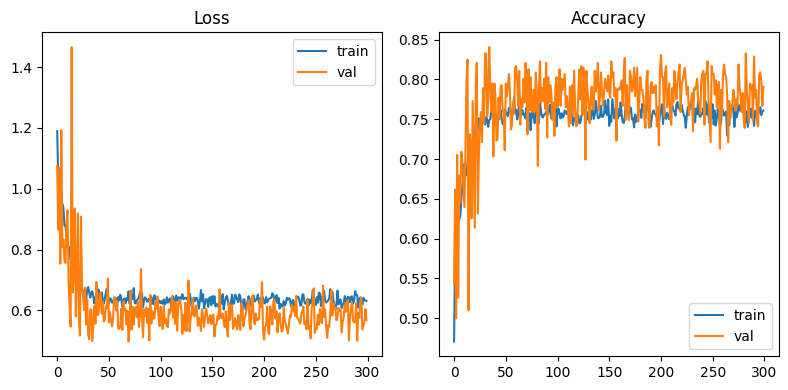

In [13]:
val_preds = np.concatenate(val_preds)
val_labels = np.concatenate(val_labels)

cm = confusion_matrix(val_labels, val_preds)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(val_labels, val_preds, target_names=class_names, digits=4))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.plot(history['train_loss'], label='train'); plt.plot(history['val_loss'], label='val'); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(history['train_acc'], label='train'); plt.plot(history['val_acc'], label='val'); plt.title("Accuracy"); plt.legend()
plt.tight_layout()
plt.show()